In [185]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

sns.set_theme(style="white", palette="viridis")
plt.style.use("fivethirtyeight")
pd.set_option("display.max_columns", None)

In [2]:
train_filename = "train.csv"
test_filename = "test.csv"

train_df = pd.read_csv(train_filename, index_col="id", na_values=["None", "none"])
test_df = pd.read_csv(test_filename, index_col="id", na_values=["None", "none"])

In [3]:
def get_basic_information(df):
    desc = pd.DataFrame(index=list(df.columns))
    desc["count"] = df.count()
    desc["nunique"] = df.nunique()
    desc["null"] = df.isnull().sum()
    desc["type"] = df.dtypes
    desc = pd.concat([desc, df.describe().T], axis=1)
    return desc

In [4]:
train_df.head(5)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [5]:
get_basic_information(train_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,1235,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,1235,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,1235,255,0,int64,1235.0,954500.401619,1.356403e+06,521399.0,528800.0,529777.0,534145.0,5305129.0
rectal_temp,1235,43,0,float64,1235.0,38.202186,7.886678e-01,35.4,37.8,38.2,38.6,40.8
pulse,1235,50,0,float64,1235.0,79.574089,2.910864e+01,30.0,53.0,76.0,100.0,184.0
respiratory_rate,1235,37,0,float64,1235.0,30.054251,1.645207e+01,8.0,18.0,28.0,36.0,96.0
temp_of_extremities,1196,4,39,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,1175,4,60,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,1214,6,21,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,1229,3,6,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_df.head(5)

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
id,,,,,,,,,,,,,,,,,,,,,
1235,no,adult,534053,38.6,40.0,20.0,normal,normal,normal_pink,less_3_sec,...,distend_small,42.0,7.5,clear,2.3,no,0,0,0,no
1236,yes,adult,528469,38.2,112.0,48.0,cool,reduced,bright_pink,more_3_sec,...,distend_small,44.0,6.0,serosanguious,2.6,no,2208,0,0,yes
1237,yes,adult,528178,37.7,66.0,12.0,cool,normal,bright_red,less_3_sec,...,distend_small,31.5,6.0,cloudy,1.6,yes,2205,0,0,yes
1238,no,adult,534784,37.1,88.0,20.0,cool,reduced,pale_cyanotic,less_3_sec,...,distend_large,75.0,81.0,NaN,1.0,yes,1400,0,0,no
1239,yes,adult,529840,38.3,50.0,12.0,NaN,normal,bright_pink,less_3_sec,...,distend_small,37.0,6.8,cloudy,2.6,yes,2208,0,0,yes


In [7]:
get_basic_information(test_df)

,count,nunique,null,type,count,mean,std,min,25%,50%,75%,max
surgery,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,824,2,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hospital_number,824,210,0,int64,824.0,1.108357e+06,1.555627e+06,521399.0,528743.0,529808.5,534644.0,5305129.0
rectal_temp,824,34,0,float64,824.0,3.824454e+01,7.852339e-01,36.0,37.8,38.2,38.6,40.8
pulse,824,49,0,float64,824.0,8.022937e+01,2.916471e+01,36.0,54.0,76.0,100.0,184.0
respiratory_rate,824,38,0,float64,824.0,3.071966e+01,1.743191e+01,9.0,18.0,28.0,36.0,96.0
temp_of_extremities,789,4,35,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peripheral_pulse,777,4,47,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mucous_membrane,811,6,13,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
capillary_refill_time,818,3,6,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# test_df has only one unique value for lesion_3 (0), so we can drop it
test_df.drop("lesion_3", axis=1, inplace=True)

In [9]:
numerical_features = list(test_df.select_dtypes(include="number").columns)
categorical_features = list(test_df.select_dtypes(exclude="number").columns)

In [10]:
print(numerical_features)
print(categorical_features)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2']
['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data']


In [181]:
for feature in categorical_features:
    train_unique = set(train_df[feature].unique())
    test_unique = set(test_df[feature].unique())
    diff = train_unique.symmetric_difference(test_unique)
    if len(diff) > 0:
        print(feature)
        print(diff)
        print(train_unique, test_unique)
        print(train_df[feature].value_counts())
        print("-" * 40)
        print(test_df[feature].value_counts())
        print()

pain
{'slight', 'moderate'}
{'depressed', 'extreme_pain', 'mild_pain', nan, 'severe_pain', 'alert', 'slight'} {'depressed', 'extreme_pain', 'mild_pain', nan, 'severe_pain', 'alert', 'moderate'}
depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: pain, dtype: int64
----------------------------------------
depressed       310
mild_pain       255
severe_pain     115
extreme_pain     82
alert            32
moderate          1
Name: pain, dtype: int64

peristalsis
{'distend_small'}
{'absent', 'normal', 'hypermotile', nan, 'hypomotile', 'distend_small'} {'absent', 'normal', 'hypermotile', nan, 'hypomotile'}
hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: peristalsis, dtype: int64
----------------------------------------
hypomotile     447
absent         297
hypermotile     39
normal          22
Name: peristalsis, dtype: int64

nasogastric_reflux
{'slight'}


In [11]:
def compute_roc_auc():
    train = train_df.copy()
    test = test_df.copy()
    train.drop("outcome", axis=1, inplace=True)  # extra column not present in test

    train["is_train"] = 1
    test["is_train"] = 0

    data = pd.concat([train, test], ignore_index=True)
    shuffled_data = data.sample(frac=1.0)
    x = shuffled_data.drop("is_train", axis=1)
    y = shuffled_data["is_train"]

    skf = StratifiedKFold(n_splits=4, random_state=0, shuffle=True)
    validation_scores = []
    predictions = np.zeros(len(data))

    for train_idx, val_idx in skf.split(x, y):
        pipeline = make_pipeline(
            ColumnTransformer(
                [
                    (
                        "cat_cols",
                        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                        categorical_features,
                    ),
                    ("num_cols", StandardScaler(), numerical_features),
                ]
            ),
            RandomForestClassifier(max_depth=6, min_samples_leaf=6),
        )
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(x_train, y_train)
        probs = pipeline.predict_proba(x_val)[:, 1]
        predictions[val_idx] = probs
        val_score = roc_auc_score(y_val, probs)
        validation_scores.append(val_score)

    fpr, tpr, _ = roc_curve(shuffled_data["is_train"], predictions)

    plt.figure(figsize=(10, 10))
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Classifier")
    plt.title(f"Validation = {np.mean(validation_scores):.5f}", weight="bold", size=16)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

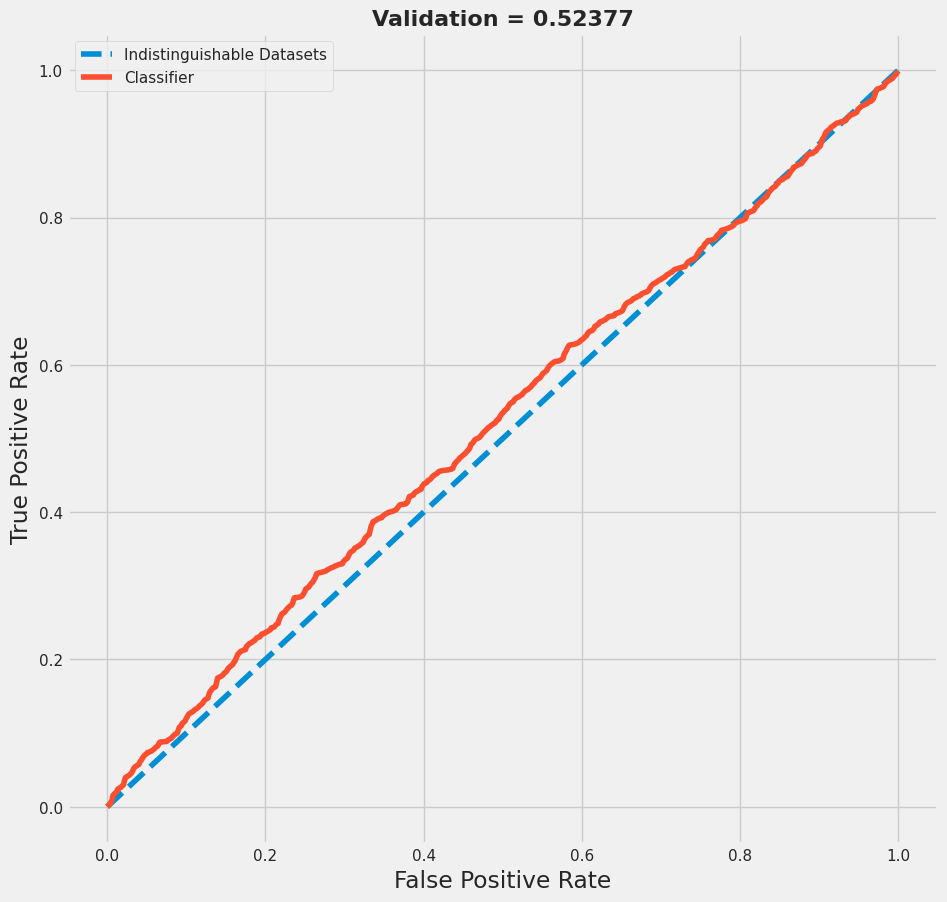

In [12]:
compute_roc_auc()

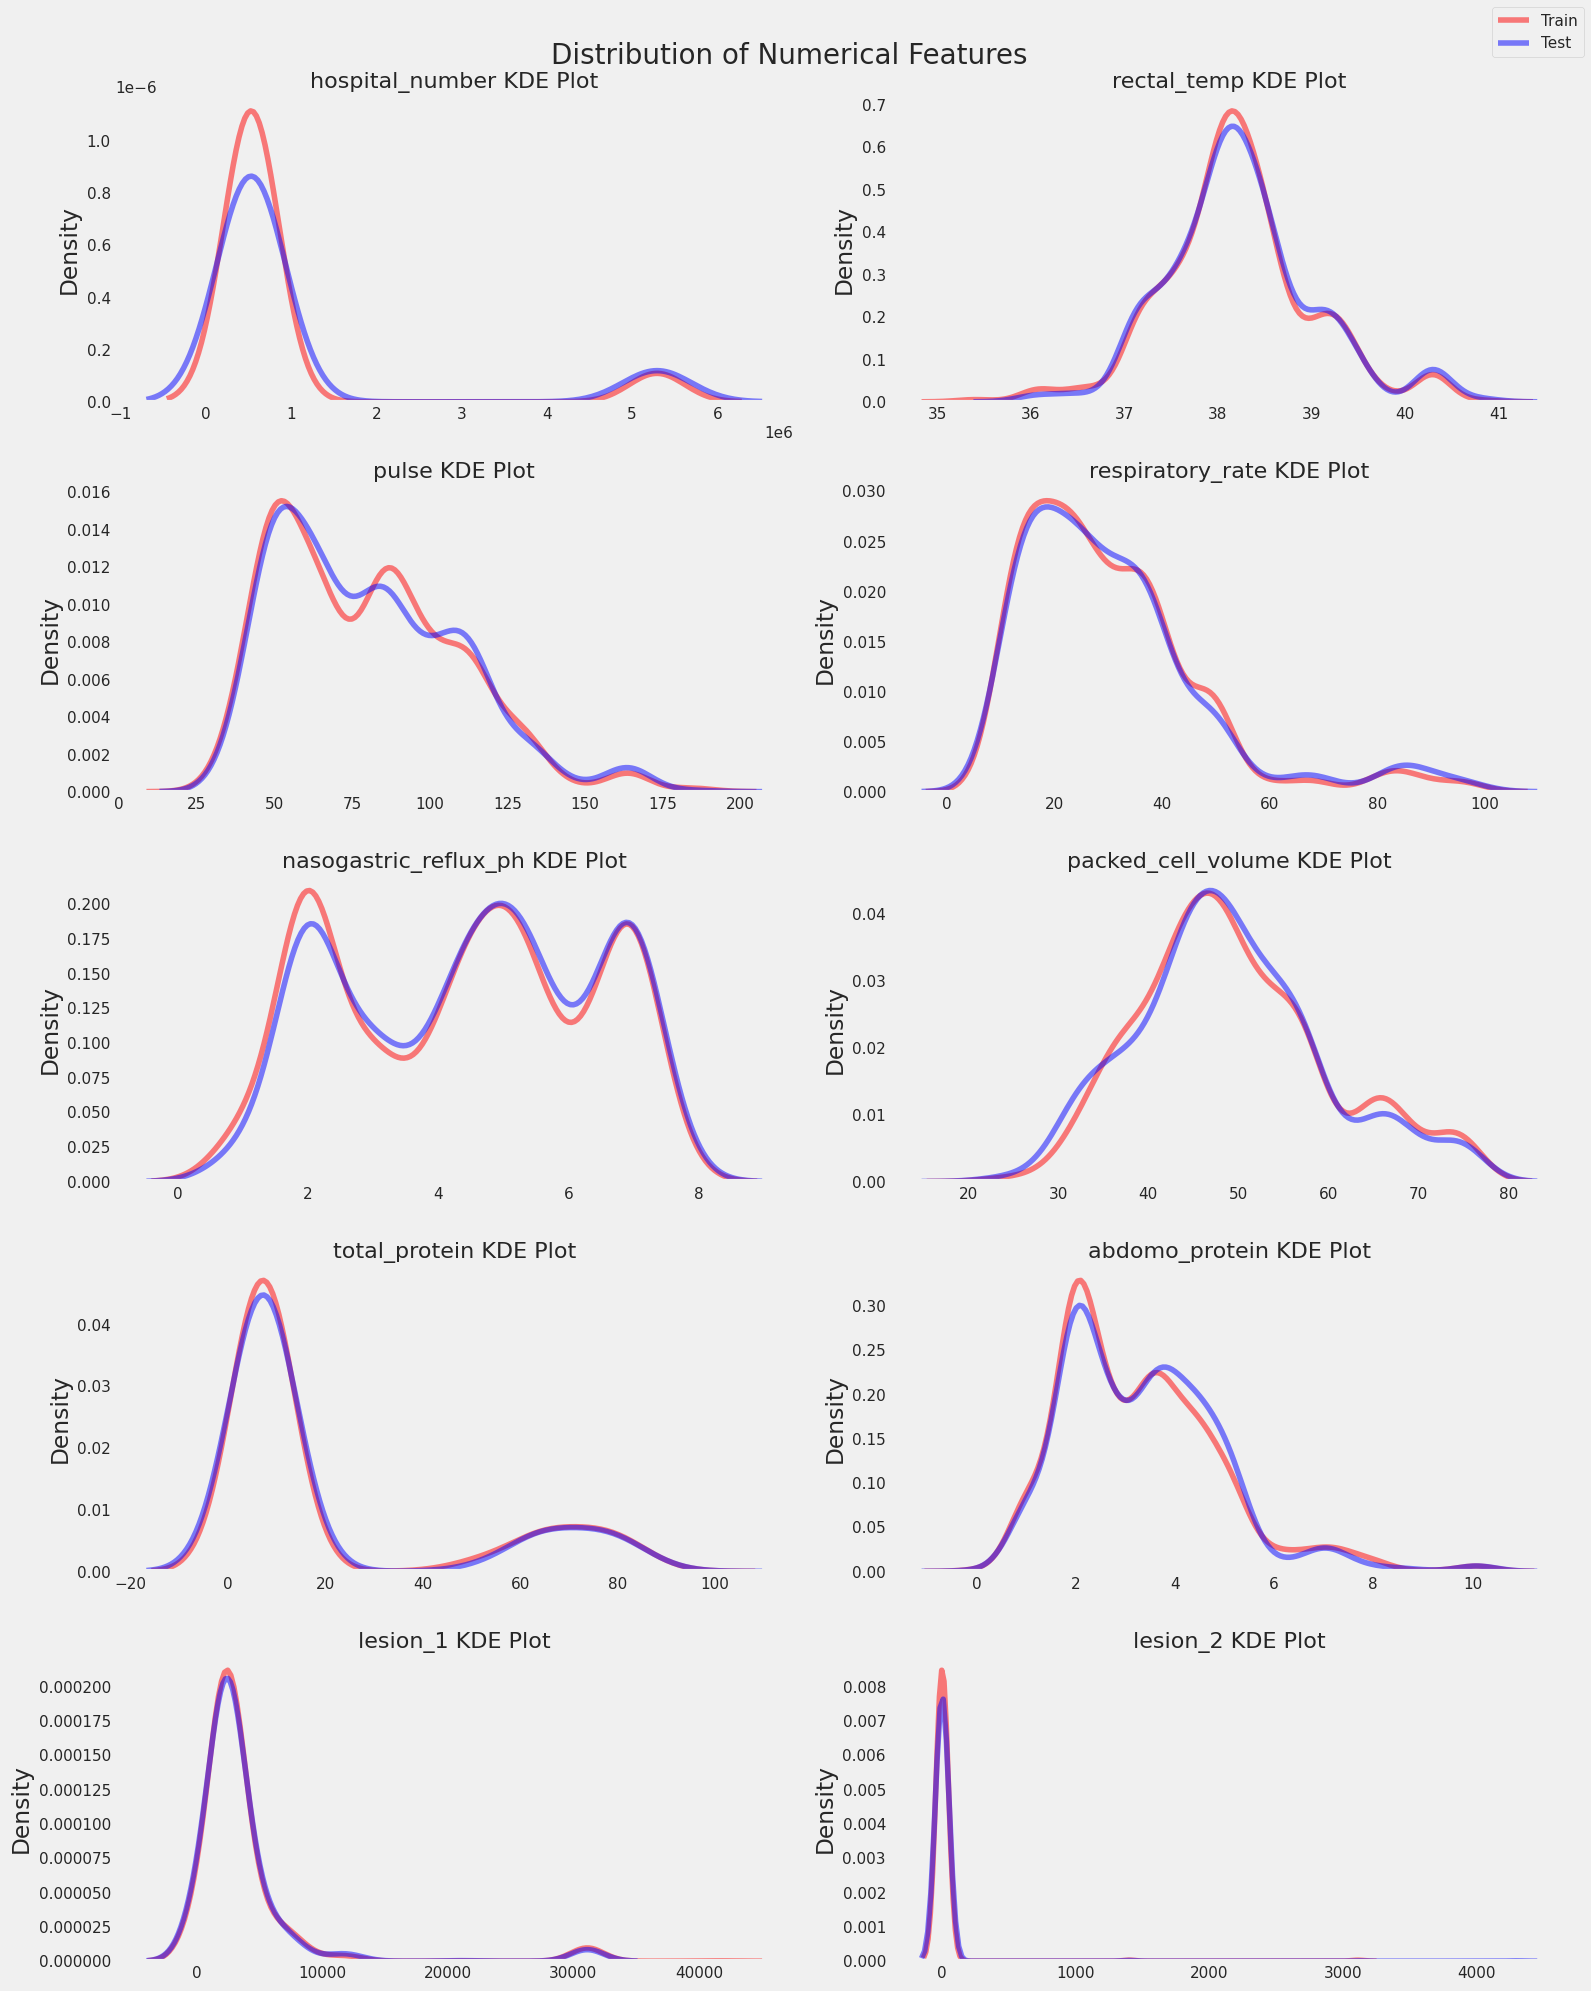

In [105]:
fig, axes = plt.subplots(len(numerical_features) // 2, 2, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.kdeplot(train_df[feature], ax=ax, color="red", alpha=0.5)
    sns.kdeplot(test_df[feature], ax=ax, color="blue", alpha=0.5)
    ax.set_title(f"{feature} KDE Plot", size=16)
    ax.grid(False)
    ax.set_xlabel(None)

fig.suptitle("Distribution of Numerical Features", fontsize=20)
fig.legend(["Train", "Test"])
plt.tight_layout()
plt.show()

In [160]:
def preprocess(df):
    df = df.copy()
    for feature in categorical_features:
        df[feature] = df[feature].fillna(df[feature].mode()[0])
    for feature in numerical_features:
        df[feature] = df[feature].fillna(df[feature].median())
    if "outcome" in df.columns:
        df["outcome"] = df["outcome"].apply(
            lambda x: 0 if x == "died" else 1 if x == "lived" else 2
        )
    return df


def train(model, cross_validator):
    df = preprocess(train_df)
    x = df
    y = df["outcome"]

    train_scores = []
    val_scores = []

    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "cat_cols",
                    OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                    categorical_features,
                ),
                ("num_cols", StandardScaler(), numerical_features),
            ]
        ),
        model,
    )

    print(f"Training Model: {model.__class__.__name__}")
    for train_idx, val_idx in cross_validator.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(x_train, y_train)
        train_preds = pipeline.predict(x_train)
        val_preds = pipeline.predict(x_val)

        train_score = f1_score(y_train, train_preds, average="micro")
        val_score = f1_score(y_val, val_preds, average="micro")
        train_scores.append(train_score)
        val_scores.append(val_score)

    mean_train, std_train = np.mean(train_scores), np.std(train_scores)
    mean_val, std_val = np.mean(val_scores), np.std(val_scores)

    print(f"  Training scores: {round(mean_train, 5)} ± {round(std_train, 5)}")
    print(f"Validation scores: {round(mean_val, 5)} ± {round(std_val, 5)}")
    print()

    return train_scores, val_scores


def predict(model):
    df = preprocess(train_df)
    x_train = df
    x_test = preprocess(test_df)
    y_train = df["outcome"]

    pipeline = make_pipeline(
        ColumnTransformer(
            [
                (
                    "cat_cols",
                    OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
                    categorical_features,
                ),
                ("num_cols", StandardScaler(), numerical_features),
            ]
        ),
        model,
    )

    print(f"Training Model: {model.__class__.__name__}")
    pipeline.fit(x_train, y_train)

    train_preds = pipeline.predict(x_train)
    train_score = f1_score(y_train, train_preds, average="micro")
    print(f"Training Score: {train_score}")

    test_preds = pipeline.predict(x_test)
    return test_preds

In [161]:
seed = 1337
np.random.seed(seed)

In [162]:
scores = pd.DataFrame()

models = [
    AdaBoostClassifier(random_state=seed),
    CatBoostClassifier(random_state=seed, verbose=0),
    ExtraTreesClassifier(random_state=seed),
    GradientBoostingClassifier(random_state=seed),
    HistGradientBoostingClassifier(random_state=seed),
    KNeighborsClassifier(),
    LinearDiscriminantAnalysis(),
    LGBMClassifier(random_state=seed),
    MLPClassifier(
        hidden_layer_sizes=[256, 128], random_state=seed, learning_rate="adaptive"
    ),
    RandomForestClassifier(random_state=seed),
    RidgeClassifier(random_state=seed),
    SVC(random_state=seed, probability=True),
    XGBClassifier(random_state=seed),
]
skf_cv = StratifiedKFold(n_splits=6, random_state=seed, shuffle=True)

In [163]:
for model in models:
    name = model.__class__.__name__
    _, scores[name] = train(model, skf_cv)

Training Model: AdaBoostClassifier
  Training scores: 0.7302 ± 0.00708
Validation scores: 0.68345 ± 0.03526

Training Model: CatBoostClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.71015 ± 0.0241

Training Model: ExtraTreesClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.70044 ± 0.02349

Training Model: GradientBoostingClassifier
  Training scores: 0.90705 ± 0.0058
Validation scores: 0.71421 ± 0.02412

Training Model: HistGradientBoostingClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.72148 ± 0.01883

Training Model: KNeighborsClassifier
  Training scores: 0.74785 ± 0.00597
Validation scores: 0.65266 ± 0.02928

Training Model: LinearDiscriminantAnalysis
  Training scores: 0.7098 ± 0.00795
Validation scores: 0.6826 ± 0.03053

Training Model: LGBMClassifier
  Training scores: 1.0 ± 0.0
Validation scores: 0.72066 ± 0.02355

Training Model: MLPClassifier
  Training scores: 0.99984 ± 0.00036
Validation scores: 0.66397 ± 0.03109

Training Model: RandomFo

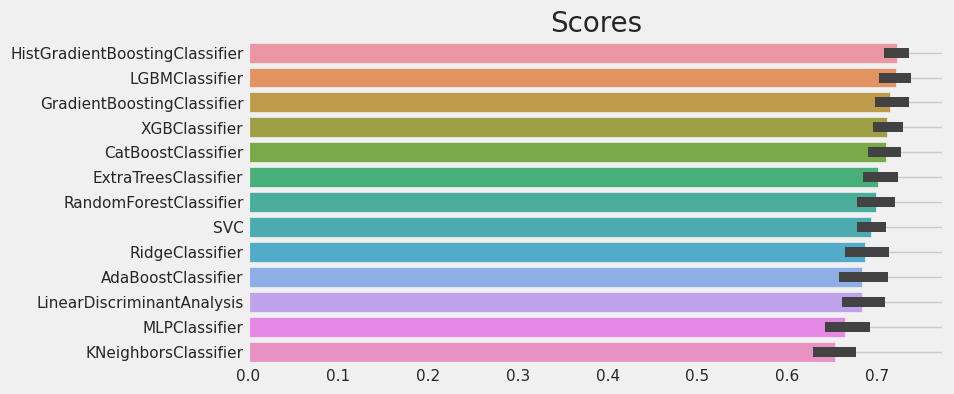

In [164]:
plt.figure(figsize=(8, 4))
sns.barplot(
    data=scores.reindex((-1 * scores).mean().sort_values().index, axis=1), orient="h"
)
plt.title("Scores", size=20)
plt.grid(None)
plt.show()

In [104]:
submission_df = pd.read_csv("sample_submission.csv", index_col="id")
# model = HistGradientBoostingClassifier(random_state=seed)
submission_df["outcome"] = predict(model)
submission_df["outcome"] = submission_df["outcome"].apply(
    lambda x: "died" if x == 0 else "lived" if x == 1 else "euthanized"
)
submission_df.to_csv(f"{model.__class__.__name__}_submission.csv")

Training Model: StackingClassifier


/home/arrow/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Score: 0.9975708502024292
